 # Homework 6: Dense Neural Networks with Pytorch

------------------------------------------------------
*Machine Learning, Master in Big Data Analytics, 2018-2019*

*Pablo M. Olmos olmos@tsc.uc3m.es*

------------------------------------------------------

In this homework you will deploy a simple Neural Network binary classifier for the Credit Default database from the [UCI repository](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients). The goal is to predict the probability of a default credit payment of different purchases, according to features such as amount of the given credit, history of past payment, or payment delay for nine months.

## Student 1: Niall O'Neill (100394545)
## Student 2: Karolina Sidlauskaite (100392576)

Make sure you have reviewed the material of the [Pytorch Facebook Udacity course](https://github.com/udacity/deep-learning-v2-pytorch.git), particularly the assigments in the `intro_to_pytorch` folder.

The homework is completely open. The following steps must be fullfilled:

- Download the dataset. 
- Check out if there are categorical or nominal variables. If so, replace them by their [one-hot encoding representation](https://towardsdatascience.com/ml-intro-5-one-hot-encoding-cyclic-representations-normalization-6f6e2f4ec001). You can use the pandas method [get_dummies](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html). Split in train (60%), validation (20%), and test (20%) sets. Normalize real variables in both sets **2 points**.
- Create a pytorch model class that defines a Neural Network with at two dense layers, non-linear activations at your choice and the appropiate final activation function for a binary classifier. Define the loss function, the batch size and the optimizer to be used. **3 points**.
- Train the model using mini-batch stochastic gradiend descent. Plot the evolution of both train and validation error rate during training. **3 points**.
- Define a new Neural Network model with four layers. Introduce Dropout as a regularization technique. Plot the evolution of both train and validation error rate during training **2 points**.

**Note:** there are tons of parameters that should be selected by cross-validation (number of hidden units per layer, activation functions, mini-batch size, etc ...). Do not worry about this issue, just make your own choice and compare both models. The goal of this homework is that you learn how to use pytorch, not to really make fine-tunning of Neural Networks.

**Note-2:** Load the dataset with pandas, export to numpy and then to a pytorch tensor with the method `torch.from_numpy()`. E.g.

`import torch`

`X_train_torch = torch.from_numpy(X_train)`

`y_train_torch = torch.from_numpy(y_train.astype(np.int64)`  


**Note-3**: You can compare the performance achieved by the Neural Network with other methods in Table 1 of this [paper](https://www.sciencedirect.com/science/article/pii/S0957417407006719)

In [1]:
import pandas as pd
import numpy as np

credit_data = pd.read_excel("default of credit card clients.xls")
credit_data = credit_data.iloc[1:,1:]

train_X = credit_data.iloc[:,:23]
train_Y = credit_data.iloc[:,-1]
train_Y = np.array(train_Y.values).reshape(30000,1)

We have 7 categorical/nominal variables: X2 - sex, X3 - education, X4 - marriage, X6 - pay0, X7 - pay2, X8 - pay3, X9 - pay4, X10 - pay5 and X11 - pay6.

In [2]:
cats = ['X2', 'X3', 'X4', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11']

train_X_cat = train_X.loc[:, cats]
train_X_cat = pd.get_dummies(train_X_cat)

train_X = train_X.drop(columns=cats)
train_X = pd.merge(train_X, train_X_cat, right_index=True, left_index=True)

Now we split the dataset into 3 sets: 60% for training data, 20% for validating and 20% for testing it.

In [3]:
from sklearn.model_selection import train_test_split

# Split into 60% train, 20% validation and 20% test sets
X_train, X_test, y_train, y_test = train_test_split(train_X, train_Y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

The real value input variables are normalized for all three sets separately:

In [4]:
from sklearn import preprocessing

X_train = preprocessing.normalize(X_train)
X_test = preprocessing.normalize(X_test)
X_val = preprocessing.normalize(X_val)

Now, we export data to torch tensor:

In [5]:
import torch
import numpy as np

X_train_torch = torch.from_numpy(X_train)
y_train_torch = torch.from_numpy(y_train.astype(np.int64))

X_val_torch = torch.from_numpy(X_val)
y_val_torch = torch.from_numpy(y_val.astype(np.int64))
                                
X_test_torch = torch.from_numpy(X_test)
y_test_torch = torch.from_numpy(y_test.astype(np.int64))

In [134]:
from torch import nn

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.dense1 = nn.Linear(91, 45)
        self.relu1 = nn.ReLU() 
        self.dense2 = nn.Linear(45, 5) 
        self.relu2 = nn.PReLU(1)
        self.out = nn.Linear(5, 1)
        self.out_act = nn.Sigmoid()

    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.dense1(x)
        x = self.relu1(x)  
        x = self.dense2(x) 
        x = self.relu2(x)
        x = self.out(x)
        x = self.out_act(x)        
        return x   

In [135]:
import torch.optim as optim

model = Network()
opt = optim.SGD(model.parameters(), lr = 0.01)
criterion = nn.MSELoss()

In [136]:
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

class TrainData(Dataset):
    def __init__(self):
        self.x=X_train_torch.float()
        self.y=y_train_torch.float()
        self.len=self.x.shape[0]
    def __getitem__(self,index):                
        return self.x[index],self.y[index]
    def __len__(self):
        return self.len

class ValidationData(Dataset):
    def __init__(self):
        self.x=X_val_torch.float()
        self.y=y_val_torch.float()
        self.len=self.x.shape[0]
    def __getitem__(self,index):                
        return self.x[index],self.y[index]
    def __len__(self):
        return self.len    
    
train_data = DataLoader(dataset=TrainData(), batch_size=5)
test_data = DataLoader(dataset=ValidationData(), batch_size=5)

train_losses, test_losses = [], []

for epoch in range(20):
    train_loss = 0
    for x,y in train_data:
        yhat=model(x)
        loss=criterion(yhat,y)
        opt.zero_grad()
        loss.backward()
        opt.step()
        train_loss += loss.item()
    #train_losses.append(train_loss/len(train_data))
    else:        
        test_loss = 0
        with torch.no_grad():
            for x,y in test_data:
                yhat = model(x)
                test_loss += criterion(yhat,y)            
            test_losses.append(test_loss/len(test_data))
            train_losses.append(train_loss/len(train_data))

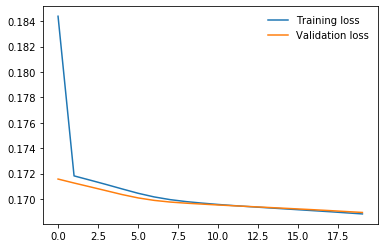

In [137]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

In [139]:
class Network2(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(91, 45)
        self.fc2 = nn.Linear(45, 30)
        self.fc3 = nn.Linear(30, 15) 
        self.fc4 = nn.Linear(15, 1)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = F.sigmoid(self.fc4(x), dim=1)
        return x   

model2 = Network()
opt = optim.SGD(model2.parameters(), lr = 0.01)
criterion = nn.MSELoss()

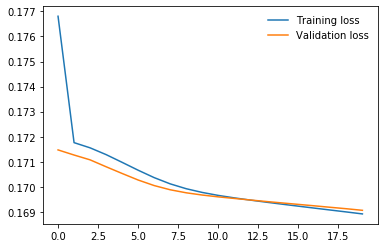

In [140]:
train_data = DataLoader(dataset=TrainData(), batch_size=5)
test_data = DataLoader(dataset=ValidationData(), batch_size=5)

train_losses, test_losses = [], []

for epoch in range(20):
    train_loss = 0
    for x,y in train_data:
        yhat=model2(x)
        loss=criterion(yhat,y)
        opt.zero_grad()
        loss.backward()
        opt.step()
        train_loss += loss.item()
    #train_losses.append(train_loss/len(train_data))
    else:        
        test_loss = 0
        with torch.no_grad():
            for x,y in test_data:
                yhat = model2(x)
                test_loss += criterion(yhat,y)            
            test_losses.append(test_loss/len(test_data))
            train_losses.append(train_loss/len(train_data))
            
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)